<h2>Dataloader</h2>

In [16]:
import os
import wandb
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
import time
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [17]:
# Define the paths
dataset_dir = '/kaggle/input/flowers-image-classification/flowers/flowers/flower_photos'
train_dir = os.path.join(dataset_dir, 'train')
valid_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

In [18]:
class FlowerDataset(Dataset):
    def __init__(self, root_dir, output_size:tuple=(256,256), transforms=None):
        self.root_dir = root_dir
        self.output_size = output_size
        self.transforms = transforms
        self.data = []
        self.classes = os.listdir(root_dir)
        
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_path):
                self.data.append((os.path.join(class_path, file_name), class_name))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        image = Image.open(img_path)
        
        if self.transforms:
            image = self.transforms(image)
        
        transform = transforms.Compose([transforms.Resize(self.output_size), transforms.ToTensor()])
        image = transform(image)
        
        label = self.classes.index(class_name)
        return image, label

In [19]:
TRANSFORMS = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.RandomRotation(15)])

train_dataset = FlowerDataset(root_dir=train_dir, transforms=TRANSFORMS)
valid_dataset = FlowerDataset(root_dir=valid_dir)
test_dataset = FlowerDataset(root_dir=test_dir)

In [20]:
def get_flower_label(dataset, label):
    # Check if the label is within the valid range
    if label < 0 or label >= len(dataset.classes):
        raise ValueError(f"Label {label} is out of range. It should be between 0 and {len(dataset.classes)-1}.")
    
    # Return the class name corresponding to the label
    return dataset.classes[label]

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

torch.Size([256, 256, 3]) dandelion


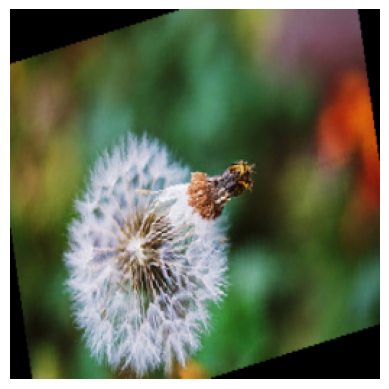

In [22]:
imgs, label = next(iter(train_dataloader))
img = imgs[0].permute((1, 2, 0))
print(img.size(), get_flower_label(train_dataset, label[0]))

plt.imshow(img)
plt.axis('off')  # Optional: Hide axes for better visualization
plt.show()


<h2>Model</h2>

In [23]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out

In [24]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

<h2>Training</h2>

In [25]:
NUM_EPOCHS=30
NUM_CLASSES=5
BATCH_SIZE=32
LR=1e-4
STEP_SIZE=20
BETAS = (0.9, 0.999)
EPS=1e-08
GAMMA=0.67
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
DEVICE

device(type='cuda')

In [27]:
class Network:
    def __init__(self, for_inference=False, pretrained=False,
                train_dataloader=train_dataloader, valid_dataloader=valid_dataloader,
                lr=LR, betas=BETAS, step_size=STEP_SIZE, device=DEVICE, 
                num_epochs=NUM_EPOCHS, eps=EPS, gamma=GAMMA, num_classes=NUM_CLASSES):
        self.for_inference=for_inference
        self.model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes).to(device)
        self.device = device
        self.pretrained = pretrained
        
        if not self.for_inference:
            self.loss_fn = nn.CrossEntropyLoss().to(device)
            self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=betas, eps=eps)
            self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)

            self.train_dataloader = train_dataloader
            self.valid_dataloader = valid_dataloader
            self.num_epochs = num_epochs
            
        if self.pretrained:
            # Load the pretrained weights
            pretrained_model = models.resnet18(weights='ResNet18_Weights.IMAGENET1K_V1')
            pretrained_dict = pretrained_model.state_dict()

            # Get the model's state dict
            model_dict = self.model.state_dict()

            # Filter out the weights for the final fully connected layer
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict and 'fc' not in k}

            # Update the model's state dict with the pretrained weights
            model_dict.update(pretrained_dict)
            self.model.load_state_dict(model_dict)
            
    def save_network(self, epoch, train_loss, valid_loss, checkpoint_path):
        checkpoint = {
            'epoch': epoch,
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'model': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'learning_rate_scheduler': self.scheduler.state_dict(),
            'network': self
        }
        torch.save(checkpoint, checkpoint_path)
        
    def load_network(self, checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        if not self.for_inference:
            self.model.load_state_dict(checkpoint['model'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.scheduler.load_state_dict(checkpoint['learning_rate_scheduler'])
        return checkpoint['epoch'], checkpoint['train_loss'], checkpoint['valid_loss']
    
    def train_step(self, images, classes):
        images, classes = images.to(self.device), classes.to(self.device)
        outputs = self.model(images)
        loss = self.loss_fn(outputs, classes)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        return loss.item()
    
    def valid_step(self, images, classes):
        self.model.eval()
        images, classes = images.to(self.device), classes.to(self.device)
        outputs = self.model(images)
        loss = self.loss_fn(outputs, classes)     
        
        return loss.item()
    
    def train_model(self):
        best_valid_loss = float('inf')
        wandb.init(project='flowers',
                   resume='allow',
                   config={
                       'lr': LR,
                       'betas': BETAS,
                       'eps': EPS,
                       'step_size': STEP_SIZE,
                       'gamma': GAMMA,
                       'num_epochs': NUM_EPOCHS,
                   })
        wandb.watch(self.model)
        
        for epoch in range(self.num_epochs):
            start = time.time()
            
            # ------------------- TRAIN -------------------
            self.model.train()
            train_loss = 0.0
            
            # Training loop
            for images, classes in tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                loss = self.train_step(images, classes)
                train_loss += loss
            train_loss /= len(self.train_dataloader)
            end = time.time()            
            
            # ------------------- VALID -------------------
            self.model.eval()
            with torch.no_grad():
                valid_loss = 0.0
            
                # Validation loop
                for images, classes in tqdm(self.valid_dataloader, desc=f'Epoch {epoch+1}/{self.num_epochs}'):
                    loss = self.valid_step(images, classes)
                    valid_loss += loss
                valid_loss /= len(self.valid_dataloader)
                    
            # ------------------- LOG -------------------
            wandb.log({
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'learning_rate': self.optimizer.param_groups[0]['lr']
            })
            self.scheduler.step()

            # ------------------- VERBOSE -------------------
            print(f'Epoch {epoch+1}/{self.num_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Time: {end-start:.2f}s')
            
            # ------------------- CHECKPOINT -------------------
            self.save_network(epoch, train_loss, valid_loss, 'model_checkpoint_latest.pth')
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                self.save_network(epoch, train_loss, valid_loss, 'model_checkpoint_best.pth')
                print("New best checkpoint saved!")
        
        wandb.finish()
        
    def inference(self, image):
        self.model.eval()
        image = image.to(self.device)
        
        with torch.no_grad():
            output = self.model(image.unsqueeze(0))  # Add batch dimension
            _, predicted_class = torch.max(output, 1)
        
        return predicted_class.item()        
    
    def train_model_continue(self, checkpoint_path):        
        start_epoch, train_loss, valid_loss = self.load_network(checkpoint_path)
        print("Previous train loss: ", train_loss)
        print("Previous valid loss: ", valid_loss)
        print("------------------- Resuming training -------------------")
        self.num_epochs -= start_epoch
        self.train_model()

In [28]:
wandb.login(key="")
classifier = Network(pretrained=True)
classifier.train_model()

wandb: Currently logged in as: namnguyen2103. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/30: 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]


Epoch 1/30 | Train Loss: 0.3833 | Valid Loss: 0.2055 | Time: 47.28s
New best checkpoint saved!


Epoch 2/30: 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]


Epoch 2/30 | Train Loss: 0.1501 | Valid Loss: 0.3064 | Time: 24.12s


Epoch 3/30: 100%|██████████| 3/3 [00:00<00:00,  8.31it/s]


Epoch 3/30 | Train Loss: 0.1058 | Valid Loss: 0.2477 | Time: 23.95s


Epoch 4/30: 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


Epoch 4/30 | Train Loss: 0.0558 | Valid Loss: 0.2803 | Time: 24.36s


Epoch 5/30: 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]


Epoch 5/30 | Train Loss: 0.0488 | Valid Loss: 0.2317 | Time: 23.88s


Epoch 6/30: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


Epoch 6/30 | Train Loss: 0.0579 | Valid Loss: 0.2418 | Time: 24.26s


Epoch 7/30: 100%|██████████| 3/3 [00:00<00:00,  8.70it/s]


Epoch 7/30 | Train Loss: 0.0362 | Valid Loss: 0.1179 | Time: 23.47s
New best checkpoint saved!


Epoch 8/30: 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]


Epoch 8/30 | Train Loss: 0.0343 | Valid Loss: 0.3173 | Time: 23.80s


Epoch 9/30: 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]


Epoch 9/30 | Train Loss: 0.0316 | Valid Loss: 0.1889 | Time: 24.20s


Epoch 10/30: 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]


Epoch 10/30 | Train Loss: 0.0307 | Valid Loss: 0.0824 | Time: 24.68s
New best checkpoint saved!


Epoch 11/30: 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]


Epoch 11/30 | Train Loss: 0.0261 | Valid Loss: 0.1554 | Time: 24.33s


Epoch 12/30: 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]


Epoch 12/30 | Train Loss: 0.0245 | Valid Loss: 0.1948 | Time: 24.07s


Epoch 13/30: 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch 13/30 | Train Loss: 0.0184 | Valid Loss: 0.1802 | Time: 24.16s


Epoch 14/30: 100%|██████████| 3/3 [00:00<00:00,  7.96it/s]


Epoch 14/30 | Train Loss: 0.0150 | Valid Loss: 0.1696 | Time: 24.26s


Epoch 15/30: 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]


Epoch 15/30 | Train Loss: 0.0182 | Valid Loss: 0.1188 | Time: 24.17s


Epoch 16/30: 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]


Epoch 16/30 | Train Loss: 0.0260 | Valid Loss: 0.3852 | Time: 24.43s


Epoch 17/30: 100%|██████████| 3/3 [00:00<00:00,  9.08it/s]


Epoch 17/30 | Train Loss: 0.0374 | Valid Loss: 0.2306 | Time: 23.82s


Epoch 18/30: 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]


Epoch 18/30 | Train Loss: 0.0219 | Valid Loss: 0.1805 | Time: 24.19s


Epoch 19/30: 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]


Epoch 19/30 | Train Loss: 0.0112 | Valid Loss: 0.2730 | Time: 24.29s


Epoch 20/30: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch 20/30 | Train Loss: 0.0086 | Valid Loss: 0.1401 | Time: 24.87s


Epoch 21/30: 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]


Epoch 21/30 | Train Loss: 0.0161 | Valid Loss: 0.1436 | Time: 24.12s


Epoch 22/30: 100%|██████████| 3/3 [00:00<00:00,  8.72it/s]


Epoch 22/30 | Train Loss: 0.0108 | Valid Loss: 0.1042 | Time: 24.39s


Epoch 23/30: 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]


Epoch 23/30 | Train Loss: 0.0087 | Valid Loss: 0.0994 | Time: 24.51s


Epoch 24/30: 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


Epoch 24/30 | Train Loss: 0.0042 | Valid Loss: 0.0746 | Time: 24.19s
New best checkpoint saved!


Epoch 25/30: 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]


Epoch 25/30 | Train Loss: 0.0035 | Valid Loss: 0.1829 | Time: 24.24s


Epoch 26/30: 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]


Epoch 26/30 | Train Loss: 0.0019 | Valid Loss: 0.1573 | Time: 24.57s


Epoch 27/30: 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]


Epoch 27/30 | Train Loss: 0.0027 | Valid Loss: 0.1361 | Time: 24.11s


Epoch 28/30: 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]


Epoch 28/30 | Train Loss: 0.0034 | Valid Loss: 0.1698 | Time: 24.66s


Epoch 29/30: 100%|██████████| 3/3 [00:00<00:00,  8.89it/s]


Epoch 29/30 | Train Loss: 0.0033 | Valid Loss: 0.2148 | Time: 23.83s


Epoch 30/30: 100%|██████████| 3/3 [00:00<00:00,  6.82it/s]


Epoch 30/30 | Train Loss: 0.0026 | Valid Loss: 0.3862 | Time: 24.18s


learning_rate,████████████████████▁▁▁▁▁▁▁▁▁▁
train_loss,█▄▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
valid_loss,▄▆▅▆▅▅▂▆▄▁▃▄▃▃▂█▅▃▅▂▃▂▂▁▃▃▂▃▄█
learning_rate,7e-05
train_loss,0.00265
valid_loss,0.38616


<h2>Testing</h2>

In [29]:
classifier.load_network("/kaggle/working/model_checkpoint_best.pth")
classifier.model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in tqdm(test_dataloader, desc='Evaluating'):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = classifier.model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy * 100:.2f}%')


Evaluating: 100%|██████████| 2/2 [00:00<00:00,  6.90it/s]

Accuracy: 86.00%
